## Introduction to pycalphad

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

### Read the thermodynamic database

In [3]:
from pycalphad import Database

In [4]:
alzn = Database('./databases/alzn_mey.tdb')

In [5]:
print("Elements in the database : ")
print(alzn.elements)

Elements in the database : 
{'ZN', '/-', 'AL', 'VA'}


In [6]:
print("Phases present in the database : ")
print(list(alzn.phases.keys()))

Phases present in the database : 
['LIQUID', 'FCC_A1', 'HCP_A3']


In [7]:
print("Constituents in the phase FCC_A1 : ")
print(alzn.phases['FCC_A1'].constituents)

Constituents in the phase FCC_A1 : 
(frozenset({Species('ZN', 'ZN1'), Species('AL', 'AL1')}),)


### Define the phases and elemets

In [8]:
phases = list(alzn.phases.keys())
elements = ['ZN', 'AL']

### Binary phase diagram

In [9]:
from pycalphad import binplot
import pycalphad.variables as v

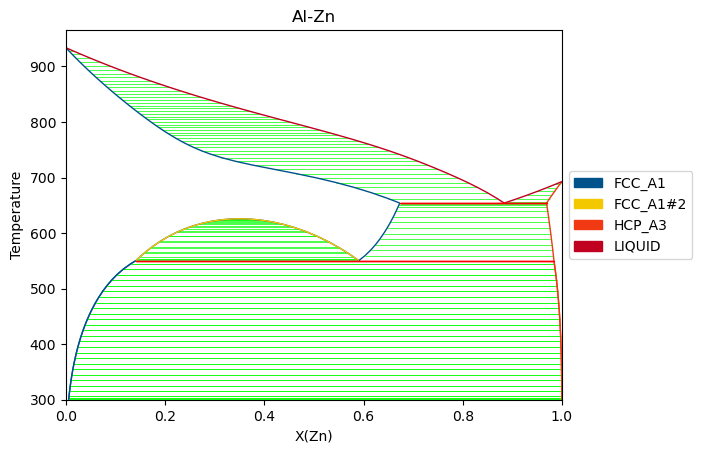

In [10]:
conditions = {v.X('ZN'):(0,1,0.02),v.T: (300, 2500, 10),v.P:101325}
binplot(alzn, elements, phases, conditions)
plt.show()

### Ploting Gibbs free energy vs temperature

In [11]:
from pycalphad import calculate
from pycalphad.plot.utils import phase_legend

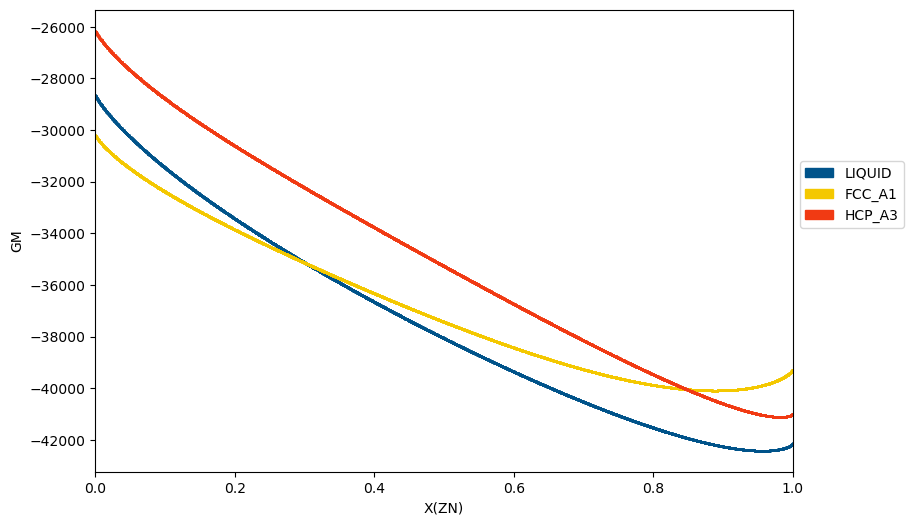

In [12]:
# Get the colors that map phase names to colors in the legend
legend_handles, color_dict = phase_legend(phases)

Temperature = 800

fig = plt.figure(figsize=(9,6))
ax = fig.gca()

# Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(RE)
for phase_name in phases:
    result = calculate(alzn, elements, phase_name, P=101325, T = Temperature, output='GM')
    ax.scatter(result.X.sel(component='ZN'), result.GM, marker='.', s=5, color=color_dict[phase_name])

# Format the plot
ax.set_xlabel('X(ZN)')
ax.set_ylabel('GM')
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()

### Spline fit the Gibbs free energy values

In [13]:
from scipy.interpolate import UnivariateSpline

In [14]:
GM_FCC_A1 = calculate(alzn, elements, 'FCC_A1', P=101325, T = Temperature, output='GM')
GM_HCP_A3 = calculate(alzn, elements, 'HCP_A3', P=101325, T = Temperature, output='GM')
GM_LIQUID = calculate(alzn, elements, 'LIQUID', P=101325, T = Temperature, output='GM')

In [15]:
X_values = GM_FCC_A1.X.sel(component='ZN').squeeze().values
GibbsFCC_A1 = GM_FCC_A1.GM.squeeze().values
GibbsHCP_A3 = GM_HCP_A3.GM.squeeze().values
GibbsLIQUID = GM_LIQUID.GM.squeeze().values

In [16]:
sortedInd = np.argsort(X_values)
X_sorted = X_values[sortedInd]
GibbsFCC_A1 = GibbsFCC_A1[sortedInd]
GibbsHCP_A3 = GibbsHCP_A3[sortedInd]
GibbsLIQUID = GibbsLIQUID[sortedInd]

In [17]:
splFCC_A1 = UnivariateSpline(X_sorted, GibbsFCC_A1, k=3, s=1)
splHCP_A3 = UnivariateSpline(X_sorted, GibbsHCP_A3, k=3, s=1)
splLIQUID = UnivariateSpline(X_sorted, GibbsLIQUID, k=3, s=1)

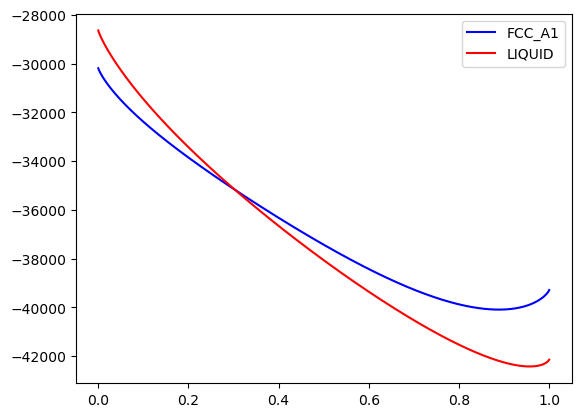

In [18]:
fig, ax = plt.subplots()
ax.plot(X_sorted, splFCC_A1(X_sorted), color='blue', label='FCC_A1')
ax.plot(X_sorted, splLIQUID(X_sorted), color='red', label='LIQUID')
ax.legend()
plt.show()

In [19]:
def objective(X):
    x1, x2 = X
    term1 = (splFCC_A1.derivative()(x2) - splLIQUID.derivative()(x1))**2
    term2 = (splFCC_A1.derivative()(x2) - (splFCC_A1(x2) - splLIQUID(x1))/(x2 - x1))**2
    return term1 + term2

# Initial guess
x0 = [0.01, 0.99]
x0 = [0, 1]
sol = minimize(objective, x0, algorithm='bfgs', verbose=True)


         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 242
         Gradient evaluations: 77


/home/arunc/anaconda3/envs/pycalphad/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


In [20]:
x_liquid = sol[0]
x_fcc = sol[1]

print("Minimum composition for HCP single phase region :", x_liquid)
print("Soluble limit in FCC_A1 : ", x_fcc)

Minimum composition for HCP single phase region : 0.4505010294736562
Soluble limit in FCC_A1 :  0.1713735512918459


### Equal chemical potential conditions

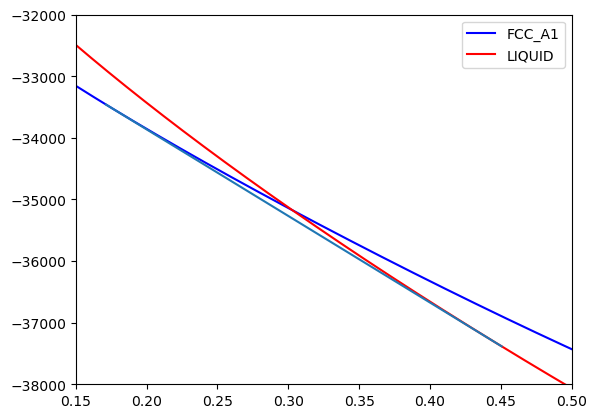

In [21]:
G1 = splLIQUID(x_liquid)
G2 = splFCC_A1(x_fcc)

fig, ax = plt.subplots()
ax.plot(X_sorted, splFCC_A1(X_sorted), color='blue', label='FCC_A1')
ax.plot(X_sorted, splLIQUID(X_sorted), color='red', label='LIQUID')
ax.legend()
ax.plot([x_liquid, x_fcc], [G1, G2])
ax.set_xlim(0.15,0.5)
ax.set_ylim(-38000, -32000)
plt.show()

#### Diffusion of couple of FCC_A1 and LIQUID

alpha = 4.80e-01 (should be < 0.5 for stability)


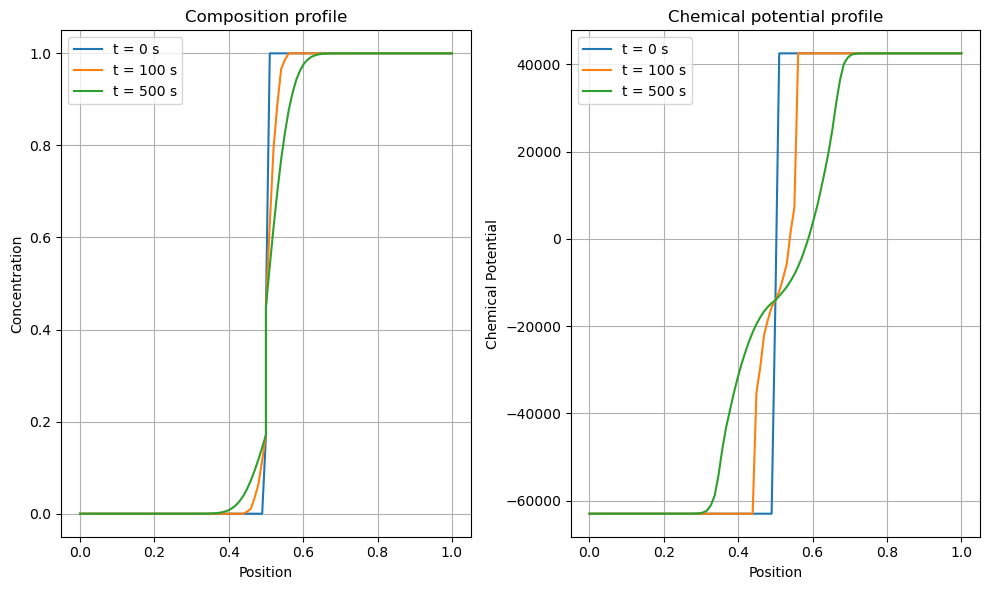

In [22]:
Nx = 50
Nt = 50
D = 2.5e-6
t_max = 1000

xfcc = np.linspace(0, 0.5, Nx) # Solid domain from 0 0.5
xl = np.linspace(0.5, 1, Nx) # LIquid domain from 0.5 1
dx = xl[1] - xl[0]
dt = t_max / Nt
alpha = D * dt / dx**2

print(f"alpha = {alpha:.2e} (should be < 0.5 for stability)")

# Initialize concentration array
Cs = np.zeros(Nx)
Cs_old = np.zeros(Nx)
Cl = np.ones(Nx)
Cl_old = np.ones(Nx)

# Store selected time steps
Cs_store = []
Chem_s = []
Cl_store = []
Chem_l = []
time_store = []

for n in range(Nt):
    for i in range(1, Nx-1):
        Cs[i] = Cs_old[i] + alpha * (Cs_old[i+1] - 2*Cs_old[i] + Cs_old[i-1])
        Cl[i] = Cl_old[i] + alpha * (Cl_old[i+1] - 2*Cl_old[i] + Cl_old[i-1])
    Cs[0] = 0.0
    Cs[Nx-1] = x_fcc
    Cl[0] =  x_liquid
    Cl[Nx-1] = 1.0

    Cs_old = Cs.copy()
    Cl_old = Cl.copy()

    # Store results at specific times
    if n in [int(Nt * frac) for frac in [0, 0.1, 0.5, 1.0]]:
        Cs_store.append(Cs_old.copy())
        Chem_s.append(splFCC_A1.derivative()(Cs_old))
        Cl_store.append(Cl_old.copy())
        Chem_l.append(splLIQUID.derivative()(Cl_old))
        time_store.append(n*dt)

#plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

for i in range(len(time_store)):
    x_full = np.concatenate((xfcc, xl))
    C_full = np.concatenate((Cs_store[i], Cl_store[i]))
    Chem_full = np.concatenate((Chem_s[i], Chem_l[i]))

    label = f"t = {float(time_store[i]):.0f} s"
    axes[0].plot(x_full, C_full, label=label)
    axes[1].plot(x_full, Chem_full, label=label)

axes[0].set_xlabel("Position")
axes[0].set_ylabel("Concentration")
axes[0].set_title("Composition profile")
axes[0].legend()
axes[0].grid()

axes[1].set_xlabel("Position")
axes[1].set_ylabel("Chemical Potential")
axes[1].set_title("Chemical potential profile")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()